In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Extract values from matrix; this is QUBO specific, but the rest of the code can take nonquadratic functions as well.

In [69]:
def qubo_values(QuadraticForm):
    phi = np.empty(1 << QuadraticForm.shape[0], dtype=int)
    #ran = np.arange(QuadraticForm.shape[0])
    for idx, conf in enumerate((np.arange(phi.shape[0]).reshape(-1, 1) >> np.arange(QuadraticForm.shape[0]))%2):
    #for x, _ in enumerate(phi):
    #    conf = (x >> ran)%2
        phi[idx] = np.dot(conf@QuadraticForm, conf)
    
    return phi

# the next function takes the following arguments:
# phi     : from qubo_values

# delta   : the parameter of fixed-point Grover

# l       : the number of queries

# p       : the distribution of values (p.shape == values.shape)



# the output is an updated distribution of values

In [10]:
def fpgas_updater(phi, delta, l, p):
    N = p.shape[0]
    p_new = np.zeros(N)
    for y in np.unique(phi):
        larger_than_y_filter, equals_to_y_filter = np.where(phi > y)[0], np.where(phi == y)[0]
        larger_than_y_count, equals_to_y_count = larger_than_y_filter.shape[0], equals_to_y_filter.shape[0]

        py = p[equals_to_y_filter[0]]
        if larger_than_y_count > 0:
            inner_chebishev = np.cosh(np.arccosh(1 / delta) / (2 * l + 1)) * np.sqrt(1 - larger_than_y_count / N)
            if inner_chebishev <= 1:
                P_failure = np.square(np.cos(np.arccos(inner_chebishev) * (2 * l + 1))  * delta)
            else:
                P_failure = np.square(np.cosh(np.arccosh(inner_chebishev) * (2 * l + 1))  * delta)
            
            p_new[larger_than_y_filter] += py * (1 - P_failure) * equals_to_y_count / larger_than_y_count
            p_new[equals_to_y_filter] += py * P_failure
        else:
            p_new[equals_to_y_filter] += py

    return p_new

# the next function takes the following arguments:
# phi     : from qubo_values

# m       : the number of queries

# p       : the distribution of values (p.shape == values.shape)



# the output is an updated distribution of values

In [11]:
def gas_updater(phi, m, p):
    N = p.shape[0]
    p_new = np.zeros(N)
    for y in np.unique(phi):
        larger_than_y_filter, equals_to_y_filter = np.where(phi > y)[0], np.where(phi == y)[0]
        larger_than_y_count, equals_to_y_count = larger_than_y_filter.shape[0], equals_to_y_filter.shape[0]

        py = p[equals_to_y_filter[0]]
        if larger_than_y_count > 0:
            theta = 2 * np.arcsin(np.sqrt(larger_than_y_count / N)) / np.pi
            P_failure = (1 + np.sinc(2 * m * theta) / np.sinc(theta)) / 2
            
            p_new[larger_than_y_filter] += py * (1 - P_failure) * equals_to_y_count / larger_than_y_count
            p_new[equals_to_y_filter] += py * P_failure
        else:
            p_new[equals_to_y_filter] += py

    return p_new

# graph to generate QUBO for testing

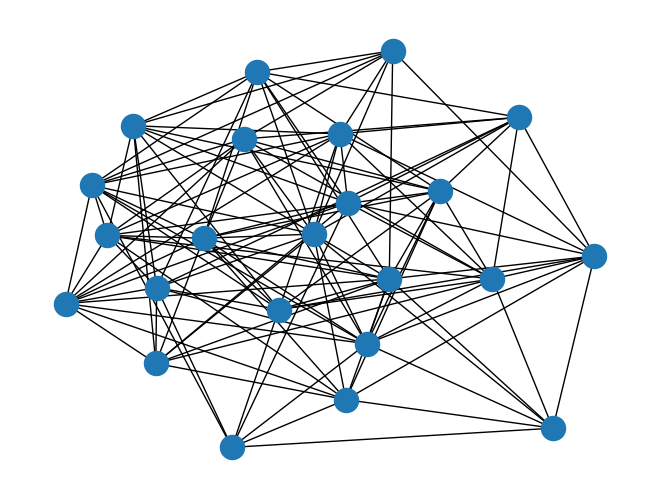

In [71]:
# random, connected graph
NumberOfVertices, EdgeProbability = 23, 5e-1
Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
while not nx.is_connected(Graph):
    Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
nx.draw(Graph, with_labels=False)
GraphLaplacian = nx.laplacian_matrix(Graph).toarray()

# let's get rid of the vertex with the highest degree; this step is not necessary, but saves one qubit
maxdegvertex = np.argmax(np.diag(GraphLaplacian))
Q = np.delete(np.delete(GraphLaplacian, maxdegvertex, 0), maxdegvertex, 1)

cuts = qubo_values(Q)
MaxCut = np.max(cuts)

# simulation

In [72]:
rounds = 4 # number of iterations to run

In [73]:
Lambda = 6/5 # paramaters for GAS; Lambda = 6/5 is from Boyer et al.

In [74]:
delta, alpha = 0.4, 2 # paramaters for FPGAS / far from optimal at such a low qubit number

In [75]:
# runing the simulation
p_gas = np.ones(cuts.shape[0]) / cuts.shape[0]
p_fpgas = np.ones(cuts.shape[0]) / cuts.shape[0]
l = 1
m = 1
for idx in range(rounds):
    p_fpgas, p_gas = fpgas_updater(cuts, delta, np.ceil(l), p_fpgas), gas_updater(cuts, np.ceil(m), p_gas)
    m *= Lambda
    l *= alpha

# statistics

In [76]:
E_random = np.sum(cuts) / cuts.shape[0]
E_gas = np.dot(p_gas, cuts)
E_fpgas = np.dot(p_fpgas, cuts)

cuts_squared = np.square(cuts)

sigma_random = np.sqrt(np.sum(cuts_squared) / cuts.shape[0] - E_random**2)
sigma_gas = np.sqrt(np.dot(p_gas, cuts_squared) - E_gas**2)
sigma_fpgas = np.sqrt(np.dot(p_fpgas, cuts_squared) - E_fpgas**2)

In [77]:
print(f"\t\tmaximal cut\t= {MaxCut}\n\t\t---------------------")
print(f"\t\trandom\tGAS\tFPGAS\n")
print(f"E[cut]\t\t{(E_random / MaxCut):.2%}\t{(E_gas / MaxCut):.2%}\t{(E_fpgas / MaxCut):.2%}")
print(f"D[cut]\t\t{(sigma_random / MaxCut):.2%}\t{(sigma_gas / MaxCut):.2%}\t{(sigma_fpgas / MaxCut):.2%}")

		maximal cut	= 81
		---------------------
		random	GAS	FPGAS

E[cut]		73.46%	82.07%	86.85%
D[cut]		6.73%	4.49%	3.58%


In [78]:
# cut statistics
random_chance = np.array([np.sum(np.where(cuts == cut, 1, 0)) for cut in range(MaxCut + 1)]) / cuts.shape[0]
distribution_gas = np.array([np.sum(np.where(cuts == cut, p_gas, 0)) for cut in range(MaxCut + 1)])
distribution_fpgas = np.array([np.sum(np.where(cuts == cut, p_fpgas, 0)) for cut in range(MaxCut + 1)])

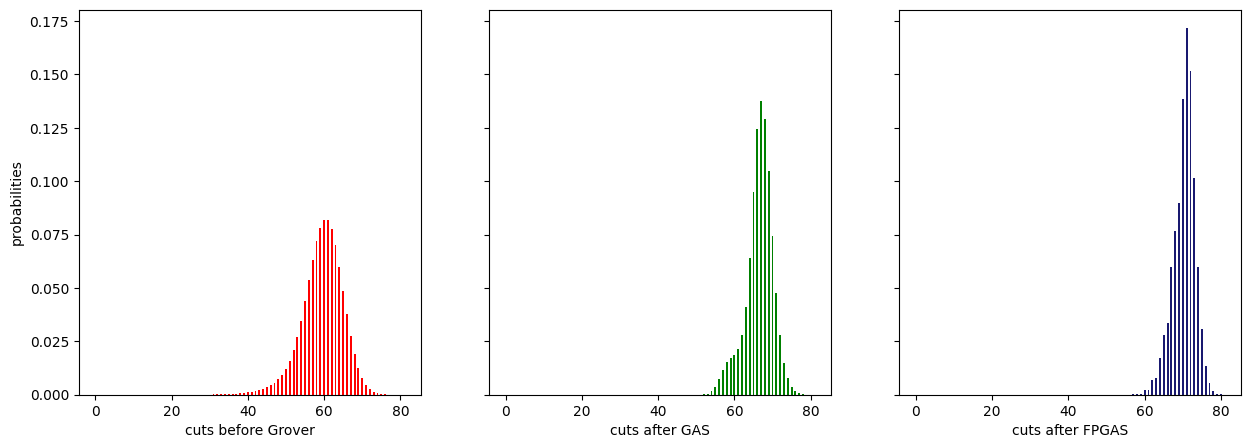

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

axs[0].bar(np.arange(random_chance.shape[0]),
           random_chance,
           width=0.5,
           color="red")
axs[0].set(xlabel=f"cuts before Grover",
           ylabel=f"probabilities")

axs[1].bar(np.arange(distribution_gas.shape[0]),
           distribution_gas,
           width=0.5,
           color="green")
axs[1].set(xlabel=f"cuts after GAS")

axs[2].bar(np.arange(distribution_fpgas.shape[0]),
           distribution_fpgas,
           width=0.5,
           color="midnightblue")
axs[2].set(xlabel=f"cuts after FPGAS")

plt.show()

# probabilities of finding MaxCut

In [83]:
print(f"{random_chance[MaxCut]:.4%}\t{distribution_gas[MaxCut]:.4%}\t{distribution_fpgas[MaxCut]:.4%}")

0.0000%	0.0003%	0.0022%


# improvemnts

In [84]:
distribution_fpgas[MaxCut] / random_chance[MaxCut], distribution_fpgas[MaxCut] / distribution_gas[MaxCut]

(np.float64(94.06351019801201), np.float64(8.369764991690941))

# with repetition

In [85]:
def repeater(distribution, r):
    CDF = np.power(np.cumsum(distribution), r)
    distribution_new = CDF - np.roll(CDF, 1)
    distribution_new[0] = CDF[0]
    return distribution_new    

In [86]:
reps = NumberOfVertices**2

In [87]:
# cut statistics
random_chance_with_reps = repeater(random_chance, reps)
distribution_gas_with_reps = repeater(distribution_gas, reps)
distribution_fpgas_with_reps = repeater(distribution_fpgas, reps)

In [88]:
E_random_with_reps = np.dot(random_chance_with_reps, np.arange(random_chance_with_reps.shape[0]))
E_gas_with_reps = np.dot(distribution_gas_with_reps, np.arange(random_chance_with_reps.shape[0]))
E_fpgas_with_reps = np.dot(distribution_fpgas_with_reps, np.arange(random_chance_with_reps.shape[0]))

sigma_random_with_reps = np.sqrt(np.dot(random_chance_with_reps, np.square(np.arange(random_chance_with_reps.shape[0]) - E_random_with_reps)))
sigma_gas_with_reps = np.sqrt(np.dot(distribution_gas_with_reps, np.square(np.arange(random_chance_with_reps.shape[0]) - E_gas_with_reps)))
sigma_fpgas_with_reps = np.sqrt(np.dot(distribution_fpgas_with_reps, np.square(np.arange(random_chance_with_reps.shape[0]) - E_fpgas_with_reps)))

In [89]:
print(f"\t\tmaximal cut\t= {MaxCut}\n\t\t---------------------")
print(f"\t\tnumber of reps\t= {reps}\n\t\t---------------------")
print(f"\t\trandom\tGAS\tFPGAS\n")
print(f"E[cut]\t\t{(E_random_with_reps / MaxCut):.2%}\t{(E_gas_with_reps / MaxCut):.2%}\t{(E_fpgas_with_reps / MaxCut):.2%}")
print(f"D[cut]\t\t{(sigma_random_with_reps / MaxCut):.2%}\t{(sigma_gas_with_reps / MaxCut):.2%}\t{(sigma_fpgas_with_reps / MaxCut):.2%}")

		maximal cut	= 81
		---------------------
		number of reps	= 529
		---------------------
		random	GAS	FPGAS

E[cut]		90.90%	94.22%	96.45%
D[cut]		1.92%	1.45%	1.17%


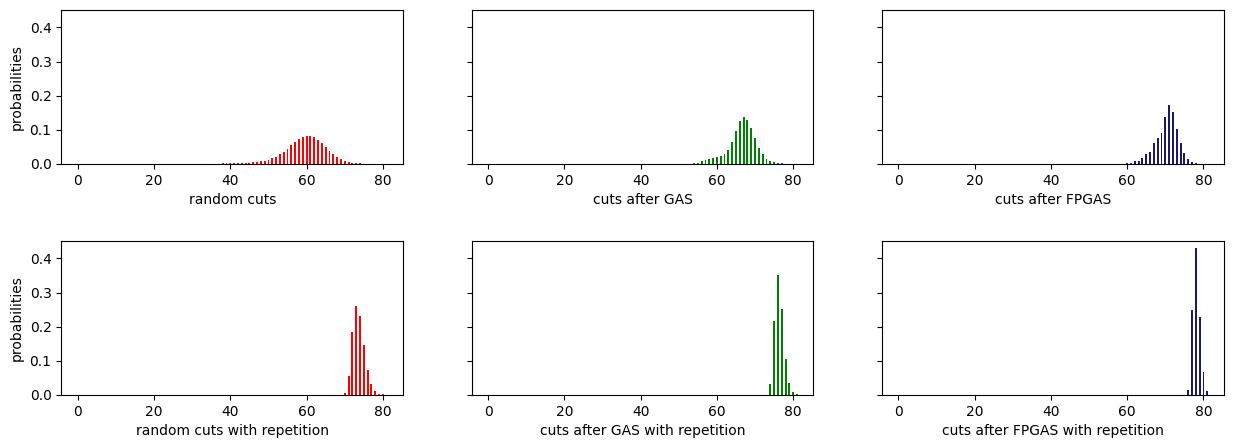

In [95]:
reps = 10

fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15, 5))

axs[0, 0].bar(np.arange(random_chance.shape[0]),
           random_chance,
           width=0.5,
           color="red")
axs[0, 0].set(xlabel=f"random cuts",
           ylabel=f"probabilities")

axs[0, 1].bar(np.arange(distribution_gas.shape[0]),
           distribution_gas,
           width=0.5,
           color="green")
axs[0, 1].set(xlabel=f"cuts after GAS")

axs[0, 2].bar(np.arange(distribution_fpgas.shape[0]),
           distribution_fpgas,
           width=0.5,
           color="midnightblue")
axs[0, 2].set(xlabel=f"cuts after FPGAS")

axs[1, 0].bar(np.arange(random_chance.shape[0]),
           random_chance_with_reps,
           width=0.5,
           color="red")
axs[1, 0].set(xlabel=f"random cuts with repetition",
           ylabel=f"probabilities")

axs[1, 1].bar(np.arange(distribution_gas.shape[0]),
           distribution_gas_with_reps,
           width=0.5,
           color="green")
axs[1, 1].set(xlabel=f"cuts after GAS with repetition")

axs[1, 2].bar(np.arange(distribution_fpgas.shape[0]),
           distribution_fpgas_with_reps,
           width=0.5,
           color="midnightblue")
axs[1, 2].set(xlabel=f"cuts after FPGAS with repetition")

plt.subplots_adjust(hspace=0.5)

plt.show()